In [19]:
# !pip install -U accelerate
# !pip install -U transformers

In [20]:
import pandas as pd
df = pd.read_csv("./dataset/problems.csv", usecols=["description", "labels"])
df.head(10)

,description,labels
0,John gave Jack a very hard problem. He wrote a...,['math']
1,Due to the recent popularity of the Deep learn...,"['dynamic programming', 'matrices']"
2,Bill is a famous mathematician in BubbleLand. ...,"['greedy', 'sorting']"
3,The competitors of Bubble Cup X gathered after...,"['shortest path', 'graphs', 'binary search']"
4,John has just bought a new car and is planning...,['dynamic programming']
5,"Consider an array A with N elements, all being...","['combinatorics', 'number theory', 'math']"
6,The citizens of BubbleLand are celebrating the...,"['dynamic programming', 'geometry']"
7,This story is happening in a town named Bubble...,"['trees', 'graphs']"
8,You are given an integer $$$x$$$ of $$$n$$$ di...,"['greedy', 'strings']"
9,You are given a Young diagram. Given diagram ...,"['greedy', 'dynamic programming', 'math']"


In [21]:
# df.shape
df.info()
# df.duplicated().sum()
# df['description'].str.len().plot.hist(bins=50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10912 entries, 0 to 10911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  10912 non-null  object
 1   labels       10912 non-null  object
dtypes: object(2)
memory usage: 170.6+ KB


In [22]:
import ast

df['labels'] = df['labels'].apply(ast.literal_eval)
# labels_cnt = [l for lab in df['labels'] for l in lab]
# label_series = pd.Series(labels_cnt).value_counts()
# print(label_series)

# print("總共有", label_series.index.nunique(), "種 labels")

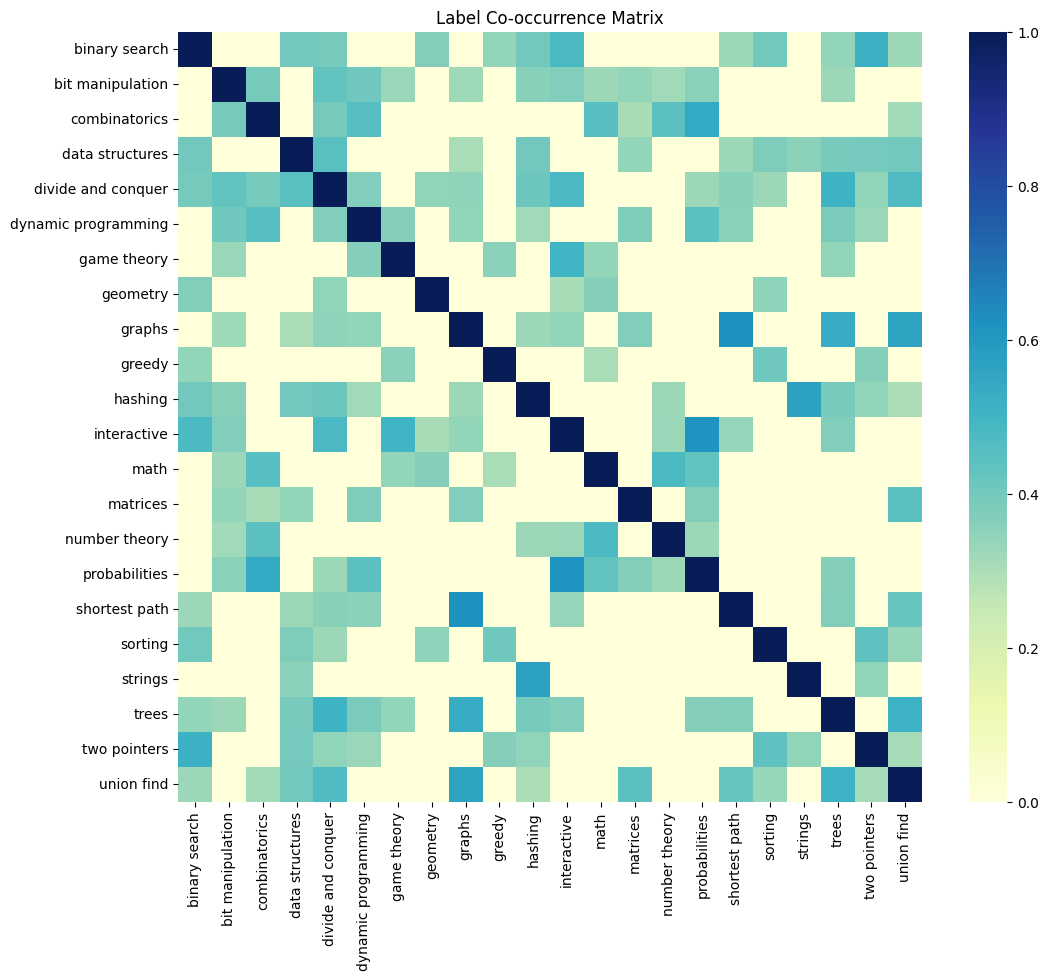

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(df["labels"]).astype('float32') # NumPy ndarray # To align label format with model prediction (both are float)
texts = df["description"].tolist()

co_matrix = np.dot(labels.T, labels)  # labels: shape (N_samples, N_labels)
total = np.sum(co_matrix)
# 機率矩陣
P_ij = co_matrix / total
# 邊際機率 P(i)
P_i = np.diag(co_matrix) / total  # shape: (n_labels,)
# 外積計算 P(i) * P(j)
P_i_P_j = np.outer(P_i, P_i)
# PMI 計算，加上小常數避免 log(0)
PMI = np.log(P_ij / (P_i_P_j + 1e-10) + 1e-10)
PMI = np.maximum(PMI, 0.0)
np.fill_diagonal(PMI, PMI.max())
# Normalize PMI to [0, 1] for soft label weight
PMI_norm = (PMI - PMI.min()) / (PMI.max() - PMI.min())
PMI_tensor = torch.tensor(PMI_norm, dtype=torch.float32)
PMI_tensor = torch.where(PMI_tensor > 0.3, PMI_tensor, torch.zeros_like(PMI_tensor))
# soft_labels = torch.matmul(torch.tensor(labels), PMI_tensor)
# soft_labels = torch.clamp(soft_labels, 0.0, 1.0)
# soft_labels = torch.round(soft_labels * 10) / 10

import seaborn as sns
import matplotlib.pyplot as plt
label_names = multilabel.classes_
plt.figure(figsize=(12, 10))
sns.heatmap(PMI_tensor, xticklabels=label_names, yticklabels=label_names, cmap='YlGnBu', annot=False)
plt.title("Label Co-occurrence Matrix")
plt.show()


In [24]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast
from skmultilearn.model_selection import IterativeStratification
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import numpy as np

In [25]:

texts_np = np.array(texts)  
labels_np = np.array(labels)

def iterative_kfold_split(X, y, k=2, test_size=0.2):
    folds = []
    # stratifier = IterativeStratification(n_splits=k, order=2, 
    #                                      sample_distribution_per_fold=[test_size, 1.0-test_size])
    stratifier = IterativeStratification(n_splits=k, order=2)
    train_idx, val_idx = next(stratifier.split(X, y))          
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]


    
    folds.append((X_train, y_train, X_val, y_val))                      
    # for train_idx, val_idx in stratifier.split(X, y):
    #     print(train_idx)
    #     print(val_idx)
    #     X_train, y_train = X[train_idx], y[train_idx]
    #     X_val, y_val = X[val_idx], y[val_idx]
    #     folds.append((X_train, y_train, X_val, y_val))
    
    return folds



In [26]:
# calculate loss_weights to deal with dataset imbalance
label_counts = labels.sum(axis=0)
# k = 500
k = 200
weights = 1.0 / np.log(label_counts + k)
weights = weights / np.max(weights)  # normalize to [0, 1]
loss_weights = torch.tensor(weights, dtype=torch.float32)
# print(multilabel.classes_)
# print(label_counts)
print(loss_weights.max())
print(loss_weights.min())

tensor(1.)
tensor(0.7331)


In [27]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, roc_curve
from transformers import EvalPrediction
import torch

from sklearn.metrics import classification_report

def find_optimal_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        fpr, tpr, th = roc_curve(y_true[:, i], y_probs[:, i])
        youdens_j = tpr - fpr
        best_th = th[np.argmax(youdens_j)]
        thresholds.append(best_th)
    # print("Optimal thresholds:", thresholds)
    return np.array(thresholds)


# def find_f1_optimal_thresholds(y_true, y_probs):
#     thresholds = []
#     y_true = (y_true >= 0.5).astype(int)
#     for i in range(y_true.shape[1]):
#         best_f1 = 0
#         best_th = 0.5
#         for th in np.linspace(0.05, 0.95, 50):
#             y_pred_i = (y_probs[:, i] >= th).astype(int)
#             f1 = f1_score(y_true[:, i], y_pred_i)
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_th = th
#         thresholds.append(best_th)
#     return np.array(thresholds)

def find_best_threshold(y_true, y_probs):
    best_f1, best_t = 0, 0
    for t in np.arange(0.1, 0.9, 0.05):
      y_pred = (y_probs > t).astype(int)
      f1 = f1_score(y_true, y_pred, average='macro')  # or macro
      if f1 > best_f1:
        best_f1, best_t = f1, t
    print("t:", best_t, "  f1:", best_f1)
    return best_t


def multi_labels_metrics(predictions, labels):
  sigmoid = torch.nn.Sigmoid()
  # probs = sigmoid(torch.Tensor(predictions))
  probs = sigmoid(torch.tensor(predictions)).detach().cpu().numpy()

  y_pred = np.zeros(probs.shape)
#   thresholds = np.maximum(find_optimal_thresholds(labels,probs), 0.05)
  thresholds = np.maximum(find_best_threshold(labels,probs), 0.05)
#   thresholds = np.full(probs.shape[1], 0.3)

  y_pred = (probs >= thresholds).astype(int)
  y_true = labels
  
  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, probs, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  label_names = multilabel.classes_
  print("\nClassification Report:")
  print(classification_report(y_true, y_pred,target_names=label_names))

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }
  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  labels = p.label_ids.astype(int) # p.label_ids
  result = multi_labels_metrics(predictions=preds,
                                labels=labels)
  return result

In [ ]:
# model
import torch
import torch.nn as nn
from transformers import DistilBertPreTrainedModel, DistilBertModel, DistilBertConfig
import matplotlib.pyplot as plt




class DistilBertWithSoftLabel(DistilBertPreTrainedModel):
    def __init__(self, config, loss_weights=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = DistilBertModel(config)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.loss_weights = loss_weights
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='none')
        # self.loss_fn = nn.BCEWithLogitsLoss() 

        if loss_weights is None:
            self.loss_weights = torch.ones(config.num_labels)
        else:
            self.loss_weights = loss_weights

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0])

        
        if labels is not None:
            loss_matrix = self.loss_fn(logits, labels)
            loss_weights = self.loss_weights.to(logits.device)
            loss = (loss_matrix * loss_weights).sum() / loss_weights.sum()
            
            return {"logits": logits, "loss": loss}
        return {"logits": logits}
    
def data_collator(batch):
    return {
        'input_ids': torch.stack([x['input_ids'] for x in batch]),
        'attention_mask': torch.stack([x['attention_mask'] for x in batch]),
        # 'labels': torch.stack([torch.tensor(x['labels'], dtype=torch.float32) for x in batch])
        'labels': torch.stack([x['labels'] for x in batch])
    }


In [29]:
# model settings
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint)
label_counts = labels.sum(axis=0)
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=len(labels[0]))
# model = DistilBertWithSoftLabel(num_labels=len(labels[0]),loss_weights=loss_weights)

In [ ]:
# tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def select_top_sentences(text, top_k=8):
    sentences = text.splitlines()
    if len(sentences) <= top_k:
        return " ".join(sentences)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)
    scores = tfidf_matrix.sum(axis=1).A1  # sum TF-IDF for each sentence
    top_indices = sorted(np.argsort(scores)[::-1][:top_k])
    top_sentences = [sentences[i] for i in top_indices]
    return " ".join(top_sentences)

def extract_problem_core(text, top_k=10):
    lines = text.splitlines()
    core_lines = []

    for line in lines:
        line_lower = line.lower()
        if any(kw in line_lower for kw in ["input", "output", "constraint", "task", "you are given"]):
            core_lines.append(line.strip())

    return " ".join(core_lines[:top_k])


class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]
    short_text = select_top_sentences(text,15)
    # short_text = extract_problem_core(text,10)
    if not isinstance(label, torch.Tensor):
        label = torch.tensor(label, dtype=torch.float32)
    else:
        label = label.detach().clone().float()

    encoding = self.tokenizer(short_text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].squeeze(0),
        'attention_mask': encoding['attention_mask'].squeeze(0),
        'token_type_ids': encoding.get('token_type_ids', torch.zeros_like(encoding['input_ids'])).squeeze(0),
        'labels': label
    }


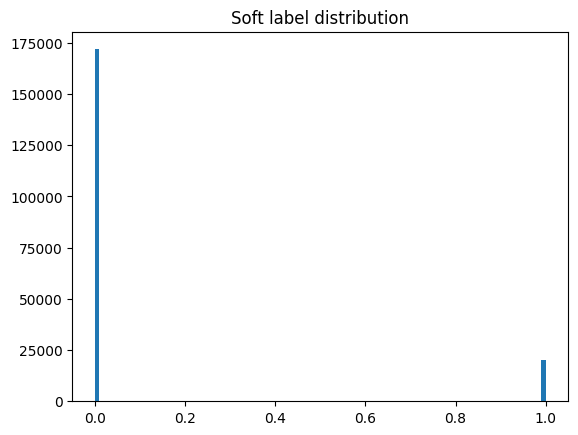

Fold 1: 8727 train, 2185 val


Epoch,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
1,4.095900,3.775363,0.750484,0.259933,0.282559,22.588800,96.729000,6.065000
2,3.522700,3.403584,0.817117,0.161868,0.416001,22.365900,97.693000,6.125000
3,3.165000,3.313251,0.833111,0.110027,0.458867,22.348600,97.769000,6.130000
4,2.857900,3.352410,0.836358,0.127252,0.477656,22.323500,97.879000,6.137000
5,2.534000,3.408593,0.832515,0.126607,0.496235,22.395300,97.565000,6.117000
6,2.202100,3.545358,0.828398,0.119971,0.503451,22.369300,97.678000,6.124000
7,1.867500,3.753972,0.825086,0.117516,0.488942,22.362400,97.708000,6.126000
8,1.579500,3.902750,0.821450,0.117038,0.497488,22.316400,97.910000,6.139000


t: 0.1   f1: 0.2825590798815873

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.15      0.88      0.25       273
   bit manipulation       0.11      0.15      0.13       157
      combinatorics       0.11      0.59      0.18       146
    data structures       0.25      1.00      0.40       542
 divide and conquer       0.09      0.14      0.11        66
dynamic programming       0.25      0.99      0.39       526
        game theory       0.00      0.00      0.00        51
           geometry       0.27      0.40      0.33        82
             graphs       0.44      0.72      0.55       390
             greedy       0.34      0.99      0.51       659
            hashing       0.00      0.00      0.00        49
        interactive       0.67      0.05      0.09        42
               math       0.36      0.97      0.52       693
           matrices       0.20      0.60      0.30        67
      number theory       0.

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.15000000000000002   f1: 0.41600145442845254

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.22      0.22      0.22       273
   bit manipulation       0.15      0.14      0.15       157
      combinatorics       0.37      0.66      0.48       146
    data structures       0.32      0.92      0.47       542
 divide and conquer       0.00      0.00      0.00        66
dynamic programming       0.25      0.96      0.40       526
        game theory       0.71      0.53      0.61        51
           geometry       0.42      0.78      0.55        82
             graphs       0.44      0.78      0.56       390
             greedy       0.43      0.91      0.58       659
            hashing       0.00      0.00      0.00        49
        interactive       0.88      0.86      0.87        42
               math       0.42      0.92      0.58       693
           matrices       0.32      0.64      0.42        67
      numbe

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.25000000000000006   f1: 0.4588673502643524

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.22      0.20      0.21       273
   bit manipulation       0.65      0.30      0.41       157
      combinatorics       0.44      0.62      0.52       146
    data structures       0.43      0.67      0.52       542
 divide and conquer       1.00      0.02      0.03        66
dynamic programming       0.38      0.65      0.48       526
        game theory       0.57      0.86      0.69        51
           geometry       0.55      0.65      0.60        82
             graphs       0.59      0.67      0.63       390
             greedy       0.50      0.81      0.62       659
            hashing       0.00      0.00      0.00        49
        interactive       0.97      0.90      0.94        42
               math       0.58      0.75      0.65       693
           matrices       0.75      0.57      0.64        67
      number

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.20000000000000004   f1: 0.47765583649604726

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.25      0.23      0.24       273
   bit manipulation       0.25      0.52      0.34       157
      combinatorics       0.46      0.64      0.54       146
    data structures       0.44      0.66      0.53       542
 divide and conquer       0.16      0.20      0.18        66
dynamic programming       0.40      0.63      0.49       526
        game theory       0.54      0.84      0.66        51
           geometry       0.46      0.82      0.59        82
             graphs       0.52      0.75      0.61       390
             greedy       0.41      0.92      0.57       659
            hashing       0.11      0.02      0.03        49
        interactive       0.78      0.90      0.84        42
               math       0.50      0.83      0.62       693
           matrices       0.73      0.61      0.67        67
      numbe

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.20000000000000004   f1: 0.4962345983088573

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.24      0.44      0.31       273
   bit manipulation       0.40      0.46      0.43       157
      combinatorics       0.39      0.71      0.50       146
    data structures       0.39      0.76      0.52       542
 divide and conquer       0.06      0.02      0.02        66
dynamic programming       0.40      0.60      0.48       526
        game theory       0.56      0.86      0.68        51
           geometry       0.62      0.61      0.61        82
             graphs       0.56      0.70      0.62       390
             greedy       0.43      0.89      0.58       659
            hashing       0.26      0.10      0.15        49
        interactive       0.90      0.90      0.90        42
               math       0.51      0.83      0.63       693
           matrices       0.77      0.60      0.67        67
      number

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.20000000000000004   f1: 0.5034508250923323

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.23      0.41      0.30       273
   bit manipulation       0.54      0.42      0.47       157
      combinatorics       0.44      0.68      0.53       146
    data structures       0.41      0.73      0.52       542
 divide and conquer       0.08      0.03      0.04        66
dynamic programming       0.38      0.66      0.48       526
        game theory       0.67      0.80      0.73        51
           geometry       0.57      0.66      0.61        82
             graphs       0.65      0.62      0.63       390
             greedy       0.47      0.80      0.59       659
            hashing       0.26      0.18      0.21        49
        interactive       1.00      0.90      0.95        42
               math       0.56      0.77      0.65       693
           matrices       0.58      0.66      0.62        67
      number

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.20000000000000004   f1: 0.4889419584092379

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.26      0.34      0.29       273
   bit manipulation       0.29      0.50      0.37       157
      combinatorics       0.45      0.64      0.53       146
    data structures       0.47      0.58      0.51       542
 divide and conquer       0.12      0.09      0.10        66
dynamic programming       0.35      0.67      0.46       526
        game theory       0.57      0.82      0.67        51
           geometry       0.44      0.74      0.55        82
             graphs       0.59      0.63      0.61       390
             greedy       0.49      0.74      0.59       659
            hashing       0.22      0.12      0.16        49
        interactive       0.97      0.90      0.94        42
               math       0.52      0.82      0.63       693
           matrices       0.62      0.66      0.64        67
      number

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.25000000000000006   f1: 0.497487889976914

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.26      0.30      0.28       273
   bit manipulation       0.33      0.46      0.39       157
      combinatorics       0.46      0.62      0.53       146
    data structures       0.40      0.73      0.52       542
 divide and conquer       0.12      0.06      0.08        66
dynamic programming       0.39      0.58      0.47       526
        game theory       0.66      0.73      0.69        51
           geometry       0.53      0.62      0.57        82
             graphs       0.56      0.68      0.61       390
             greedy       0.49      0.72      0.58       659
            hashing       0.26      0.22      0.24        49
        interactive       0.97      0.90      0.94        42
               math       0.54      0.76      0.63       693
           matrices       0.77      0.64      0.70        67
      number 

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


t: 0.20000000000000004   f1: 0.5034508250923323

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.23      0.41      0.30       273
   bit manipulation       0.54      0.42      0.47       157
      combinatorics       0.44      0.68      0.53       146
    data structures       0.41      0.73      0.52       542
 divide and conquer       0.08      0.03      0.04        66
dynamic programming       0.38      0.66      0.48       526
        game theory       0.67      0.80      0.73        51
           geometry       0.57      0.66      0.61        82
             graphs       0.65      0.62      0.63       390
             greedy       0.47      0.80      0.59       659
            hashing       0.26      0.18      0.21        49
        interactive       1.00      0.90      0.95        42
               math       0.56      0.77      0.65       693
           matrices       0.58      0.66      0.62        67
      number

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

import torch
import time
import matplotlib.pyplot as plt

start = time.time()
all_fold_metrics = []

def PMI_processing(y_train, PMI_tensor):
    hard = torch.tensor(y_train, dtype=torch.float32)
    PMI_tensor = torch.where(PMI_tensor > 0.3, PMI_tensor, torch.zeros_like(PMI_tensor))
    PMI_tensor.fill_diagonal_(0.0)  

    soft = torch.matmul(hard, PMI_tensor)
    soft = torch.clamp(soft, 0.0, 1.0)
    soft = soft ** 1.5  # Optional gamma

    alpha=1
    train_labels = hard + soft
    train_labels = alpha * hard + (1 - alpha) * soft
    # train_labels = torch.where(hard == 1, torch.tensor(1.0), train_labels) 
    train_labels = torch.where(train_labels<0.2,torch.zeros_like(train_labels),train_labels)
    return train_labels

folds = iterative_kfold_split(texts_np,labels_np,k=5)

for fold_id, (X_train, y_train, X_val, y_val) in enumerate(folds):
    train_texts = X_train.ravel().tolist()
    val_texts = X_val.ravel().tolist()

    # train_labels = torch.clamp(torch.matmul(torch.tensor(y_train), PMI_tensor), 0.0, 1.0)
    train_labels = PMI_processing(y_train,PMI_tensor=PMI_tensor)
    val_labels = torch.tensor(y_val, dtype=torch.float32)  # hard label
    # val_labels = torch.clamp(torch.matmul(torch.tensor(y_val), PMI_tensor), 0.0, 1.0)

    plt.hist(train_labels.numpy().flatten(), bins=100)
    plt.title("Soft label distribution")
    plt.show()

    train_dataset = CustomDataset(train_texts, train_labels, tokenizer,512)
    val_dataset = CustomDataset(val_texts, val_labels, tokenizer,512)
    
    model = DistilBertWithSoftLabel(config,loss_weights=loss_weights)
    
    args = TrainingArguments(
        output_dir=f"./results/fold_{fold_id}",
        per_device_train_batch_size=16,          
        per_device_eval_batch_size=16,
        num_train_epochs=10,                
        eval_strategy="epoch",             
        save_strategy="epoch",                  
        save_total_limit=2,                     
        load_best_model_at_end=True,            
        metric_for_best_model="f1",             
        greater_is_better=True,
        logging_dir=f"./logs/fold_{fold_id}",
        logging_strategy="epoch",                # 每 epoch log 資訊
        report_to=["tensorboard"],
        seed=42,
        dataloader_num_workers = 6
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print(f"Fold {fold_id+1}: {len(train_texts)} train, {len(val_texts)} val")
    trainer.train()
    metrics = trainer.evaluate()
    
    all_fold_metrics.append(metrics)

torch.cuda.synchronize()
end = time.time()
print("Total training time:", end - start)

In [32]:
for i, m in enumerate(all_fold_metrics):
    print(f"Fold {i+1} F1: {m['eval_f1']:.4f}")

avg_f1 = sum(m['eval_f1'] for m in all_fold_metrics) / len(all_fold_metrics)
print(f"\nAverage F1 across folds: {avg_f1:.4f}")


Fold 1 F1: 0.5035

Average F1 across folds: 0.5035


In [33]:
print(multilabel.classes_)

['binary search' 'bit manipulation' 'combinatorics' 'data structures'
 'divide and conquer' 'dynamic programming' 'game theory' 'geometry'
 'graphs' 'greedy' 'hashing' 'interactive' 'math' 'matrices'
 'number theory' 'probabilities' 'shortest path' 'sorting' 'strings'
 'trees' 'two pointers' 'union find']


In [34]:
from transformers import DistilBertTokenizerFast
model.save_pretrained("./best_model")
tokenizer.save_pretrained("./best_model")
torch.save(model.loss_weights, "./best_model/weights.pt")

## k=100, Threshold - roc optimal , p.label_ids > 0.8 as P
{'eval_loss': 0.5422307252883911,
 'eval_roc_auc': 0.6355803896134508,
 'eval_hamming_loss': 0.39180860367301046,
 'eval_f1': 0.5670835103814952,
 'eval_runtime': 22.0219,
 'eval_samples_per_second': 99.129,
 'eval_steps_per_second': 12.397,
 'epoch': 5.0}

## k=100, Threshold = 0.3 , p.label_ids > 0.8 as P
{'eval_loss': 0.5422307252883911,
 'eval_model_preparation_time': 0.0041,
 'eval_roc_auc': 0.6355803896134508,
 'eval_hamming_loss': 0.5140132428268022,
 'eval_f1': 0.6445478260151899,
 'eval_runtime': 21.2506,
 'eval_samples_per_second': 102.727,
 'eval_steps_per_second': 12.847}

## k=100, Threshold - f1 optimal , p.label_ids > 0.5 as P
{'eval_loss': 0.5422307252883911,
 'eval_model_preparation_time': 0.0029,
 'eval_roc_auc': 0.6209105006225866,
 'eval_hamming_loss': 0.2817015783117478,
 'eval_f1': 0.8335942488331942,
 'eval_runtime': 21.624,
 'eval_samples_per_second': 100.953,
 'eval_steps_per_second': 12.625}

## k=100, Threshold - roc optimal , p.label_ids > 0.5 as P
{'eval_loss': 0.5422307252883911,
 'eval_model_preparation_time': 0.0062,
 'eval_roc_auc': 0.6209105006225866,
 'eval_hamming_loss': 0.3794194811143964,
 'eval_f1': 0.7055115285615337,
 'eval_runtime': 19.9769,
 'eval_samples_per_second': 109.276,
 'eval_steps_per_second': 13.666}

In [35]:
print(multilabel.classes_)


['binary search' 'bit manipulation' 'combinatorics' 'data structures'
 'divide and conquer' 'dynamic programming' 'game theory' 'geometry'
 'graphs' 'greedy' 'hashing' 'interactive' 'math' 'matrices'
 'number theory' 'probabilities' 'shortest path' 'sorting' 'strings'
 'trees' 'two pointers' 'union find']


In [36]:
# import pickle
# with open("multi-label-binarizer.pkl", "wb") as f:
#   pickle.dump(multilabel, f)